In [1]:
from __future__ import division
from __future__ import absolute_import
from __future__ import print_function

In [2]:
import numpy as np 
import cPickle as pkl
from matplotlib import pyplot as plt
import pandas as pd
from theano_time_corex import *
import linearcorex
from generate_data import *
import vis_utils
import metric_utils
import random
import baselines

# Load Data

### some arguments

In [3]:
nt = 30
nv = 128
train_cnt = 6
val_cnt = 2
test_cnt = 2
data_type='stock_day'
start_date='2000-01-01'
end_date='2018-01-01'

In [4]:
train_data, val_data, test_data = load_stock_data(
        nv=nv, train_cnt=train_cnt, val_cnt=val_cnt, test_cnt=test_cnt,
        data_type=data_type, stride='full',
        start_date=start_date, end_date=end_date)

train_data = train_data[-nt:]
val_data = val_data[-nt:]
test_data = test_data[-nt:]
nt = len(train_data)

print('train shape:', np.array(train_data).shape)
print('val   shape:', np.array(val_data).shape)
print('test  shape:', np.array(test_data).shape)

Loading stock data ...
Stock data is loaded:
	train shape: (387, 6, 128)
	val   shape: (387, 2, 128)
	test  shape: (387, 2, 128)
train shape: (30, 6, 128)
val   shape: (30, 2, 128)
test  shape: (30, 2, 128)


# Baselines

In [6]:
nhidden_grid = [8, 16, 32]
tcorex_gamma_grid = [1.25, 1.5, 2.0, 3.0, 4.0]

methods = [
    (baselines.Diagonal(name='Diagonal'), {}),

    (baselines.LedoitWolf(name='Ledoit-Wolf'), {}),

    (baselines.OAS(name='Oracle approximating shrinkage'), {}),

    (baselines.PCA(name='PCA'), {'n_components': nhidden_grid}),

    (baselines.FactorAnalysis(name='Factor Analysis'), {'n_components': nhidden_grid}),

    (baselines.LinearCorex(name='Linear CorEx (applied bucket-wise)'), {
        'n_hidden': nhidden_grid,
        'max_iter': 500,
        'anneal': True}),

    (baselines.LinearCorexWholeData(name='Linear CorEx (applied on whole data)'), {
        'n_hidden': nhidden_grid,
        'max_iter': 500,
        'anneal': True}),

    (baselines.GraphLasso(name='Graphical LASSO (sklearn)'), {
        'alpha': [0.003, 0.01, 0.03, 0.1, 0.3, 1.0],
        'mode': 'lars',
        'max_iter': 100}),

    (baselines.TimeVaryingGraphLasso(name='T-GLASSO'), {
        'lamb': [0.01, 0.03, 0.1, 0.3],
        'beta': [0.03, 0.1, 0.3, 1.0],
        'indexOfPenalty': [1],  # TODO: extend grid of this one; NOTE: L2 is slow and not efficient
        'max_iter': 100}),

    (baselines.TimeVaryingGraphLasso(name='T-GLASSO (no reg)'), {
        'lamb': [0.003, 0.01, 0.03, 0.1, 0.3, 1.0],
        'beta': [0.0],
        'indexOfPenalty': [1],
        'max_iter': 100}),

    (baselines.TCorex(tcorex=TCorex, name='T-Corex (W)'), {
        'nv': nv,
        'n_hidden': nhidden_grid,
        'max_iter': 500,
        'anneal': True,
        'reg_params': {
            'l2': [],
            'l1': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        },
        'reg_type': 'W'
    }),

    (baselines.TCorex(tcorex=TCorexWeights, name='T-Corex (W, weighted samples, no reg)'), {
        'nv': nv,
        'n_hidden': nhidden_grid,
        'max_iter': 500,
        'anneal': True,
        'l1': [0.0],
        'l2': 0.0,
        'gamma': tcorex_gamma_grid,
        'reg_type': 'W',
        'init': True
    }),

    (baselines.TCorex(tcorex=TCorexWeights, name='T-Corex (W, weighted samples)'), {
        'nv': nv,
        'n_hidden': nhidden_grid,
        'max_iter': 500,
        'anneal': True,
        'reg_params': {
            # 'l1': [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0],
            'l1': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
            'l2': [],
        },
        'gamma': tcorex_gamma_grid,
        'reg_type': 'W',
        'init': True
    })
]

## Ledoit-Wolf


--------------------------------------------------------------------------------
Selecting the best parameter values for Ledoit-Wolf ...
done 0 / 1 | running with 
Training Ledoit-Wolf ...
	Elapsed time 0.1s
	current score: -205.626495183

Finished with best validation score: -205.626495183
Evaluating Ledoit-Wolf ...
	Score: -265.5408


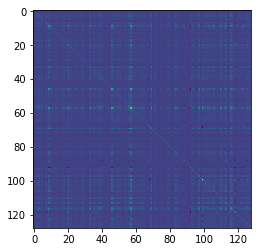

In [10]:
lw = methods[1]
lw_best_score, lw_best_params, lw_covs, _ = lw[0].select(train_data, val_data, lw[1])
lw[0].evaluate(test_data)

plt.figure()
plt.imshow(lw_covs[0])
plt.show()

## T-GLASSO (no reg.)

In [ ]:
tg_noreg = methods[-4]
tg_noreg_best_score, tg_noreg_best_params, tg_noreg_covs, _ = tg_noreg[0].select(train_data, val_data, tg_noreg[1])
tg_noreg[0].evaluate(test_data)

plt.figure()
plt.imshow(tg_noreg_covs[0])
plt.show()


--------------------------------------------------------------------------------
Selecting the best parameter values for T-GLASSO (no reg) ...
done 0 / 6 | running with lamb: 0.003	beta: 0.0	indexOfPenalty: 1	
Training T-GLASSO (no reg) ...
Use l-1 penalty function
30
lambda = 0.003, beta = 0.0
